# Trabajo Práctico 2: Análisis con Naive Bayes - Organización de Datos

**Alumnos y Padrón**
+ Craviotto Roitbarg, Mateo Exequiel - 106255 
+ Gómez, Joaquín - 103735

https://github.com/joaqogomez/Organizacion-de-datos-fiuba

## Configuraciones Iniciales
Primero, importamos las bibliotecas que vamos a utilizar:

In [1]:
import pandas as pd
import numpy as np

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import CategoricalNB
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV

In [3]:
from preprocessing import dividir_dataset
from preprocessing import preparar_dataset
from preprocessing import traer_variables_categoricas
from preprocessing import aplicar_one_hot_encoding
from preprocessing import traer_variables_discretas
from preprocessing import traer_variables_numericas

In [4]:
from funciones_auxiliares import graficar_auc_roc
from funciones_auxiliares import traer_df

## Carga del set de datos
Cargamos el dataset y aplicamos las funciones necesarias para adecuarlo al modelo. También segmentamos el dataset en X e y (target):

In [5]:
df = traer_df()
df = preparar_dataset(df)
X, y = dividir_dataset(df)

# CategoricalNB
Comenzamos por Categorical Naive Bayes, utilizando las variables categóricas únicamente.

Definimos el mejor alpha (hiperparámetro) para Categorical Naive Bayes mediante la siguiente función de búsqueda. Nos quedamos con el alpha que maximice la métrica de comparación utilizada, que es AUC-ROC. Para compararlos, usamos k-folds cross validation.

In [6]:
def definir_mejor_alpha(X, y, modelo):
    params = {'alpha': [0.001,0.01,0.5,0.3,0.1,1,2,3,5,10]}
    grid_search = GridSearchCV(modelo, params, scoring='roc_auc', n_jobs=-1, cv=5).fit(X, y)    
    return grid_search.best_params_

### Entrenamiento y predicción con el dataset original
Buscamos el mejor alpha para este dataset, con la función anteriormente mencionada.

A continuación vemos todos los features del dataset. Queremos quedarnos con las variables categóricas únicamente.

In [7]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 12 columns):
 #   Column                                      Non-Null Count  Dtype 
---  ------                                      --------------  ----- 
 0   anios_estudiados                            32561 non-null  int64 
 1   barrio                                      32561 non-null  object
 2   categoria_de_trabajo                        32561 non-null  object
 3   edad                                        32561 non-null  int64 
 4   educacion_alcanzada                         32561 non-null  object
 5   estado_marital                              32561 non-null  object
 6   ganancia_perdida_declarada_bolsa_argentina  32561 non-null  int64 
 7   genero                                      32561 non-null  object
 8   horas_trabajo_registradas                   32561 non-null  int64 
 9   religion                                    32561 non-null  object
 10  rol_familiar_registrad

Nos quedamos con los features categóricos y realizamos el split del dataset:

In [8]:
X_categoricas = traer_variables_categoricas(X)
X_categoricas = aplicar_one_hot_encoding(X_categoricas)
X_train, X_test, y_train, y_test = train_test_split(X_categoricas, y, test_size=0.25, random_state=0)

Buscamos el mejor alpha para los features categóricos:

In [9]:
mejor_combinacion = definir_mejor_alpha(X_categoricas, y, CategoricalNB())

Observamos que el mejor hiperparámetro alpha es el siguiente:

In [10]:
mejor_alpha = mejor_combinacion['alpha']
print(f'Mejor alpha: {mejor_alpha}')

Mejor alpha: 0.3


Entrenamos Categorical Naive Bayes con dicho hiperparámetro:

In [11]:
categoricalNB = CategoricalNB(alpha = mejor_alpha)
categoricalNB.fit(X_train, y_train)

CategoricalNB(alpha=0.3)

Luego, hacemos que este prediga sobre el subset de validation. A continuación se muestra el gráfico de la curva ROC y su respectivo score en la métrica AUC-ROC.

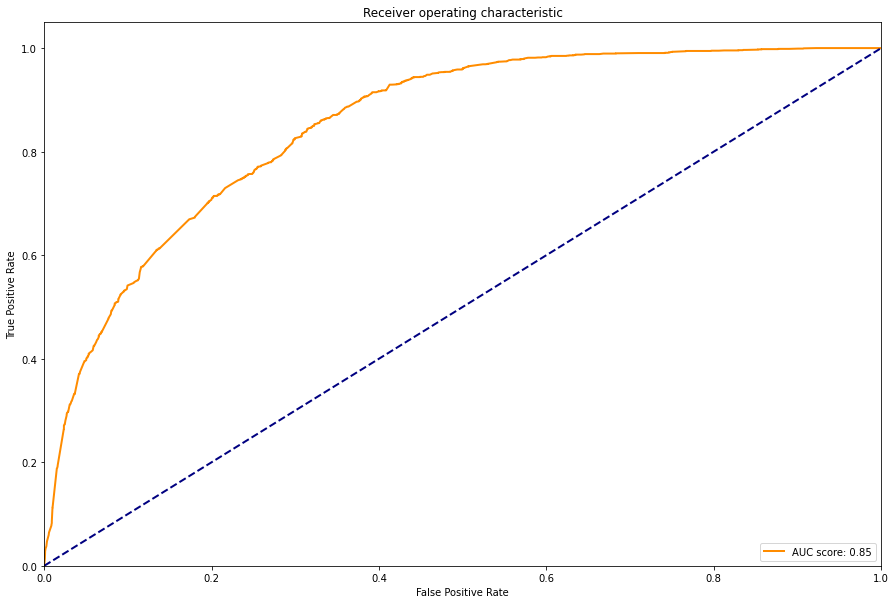

El valor de la metrica AUC-ROC para este modelo es: 0.8517291686224895


In [12]:
y_pred = categoricalNB.predict(X_test)
y_pred_proba = categoricalNB.predict_proba(X_test)[:,1]
graficar_auc_roc(y_test,y_pred_proba)

Podemos observar que el AUC score dio bastante alto, 0.85. Se podría decir que Categorical Naive Bayes es un clasificador competente, dentro de los modelos que probamos.

Luego, imprimimos el classification report:

In [13]:
print(classification_report(y_test, y_pred, target_names=['No Tiene Alto Valor Adquisitivo', 'Tiene Alto Valor Adquisitivo'],digits=3))

                                 precision    recall  f1-score   support

No Tiene Alto Valor Adquisitivo      0.896     0.798     0.844      6159
   Tiene Alto Valor Adquisitivo      0.532     0.713     0.609      1982

                       accuracy                          0.777      8141
                      macro avg      0.714     0.756     0.727      8141
                   weighted avg      0.808     0.777     0.787      8141



Por último, mostramos la matriz de confusión correspondiente:

In [14]:
from funciones_auxiliares import graficar_matriz_confusion

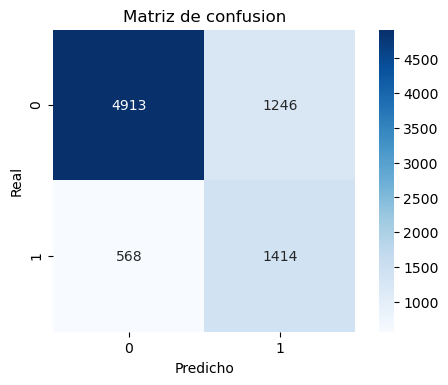

In [15]:
graficar_matriz_confusion(y_test, y_pred)

Nos quedamos con las probabilidades predichas por el modelo en cuestión, tanto para el subset de entrenamiento como para el de validation, para más adelante hacer un ensamble. 

In [16]:
probabilidades_categorical = categoricalNB.predict_proba(X_train)
probabilidades_x_test_categorical = categoricalNB.predict_proba(X_test)

### Entrenamiento y predicción con el dataset ampliado
Como otra técnica de preprocesamiento, decidimos expandir el dataset utilizando clustering para obtener cuatro nuevas columnas. Las columnas corresponden a la utilización de K-means con 2, 4, 6 y 10 como cantidad de clusters usados. 

In [17]:
from preprocessing import expandir_dataset

Expandimos el dataset y realizamos el split del mismo en los subsets de entrenamiento y validación.

In [18]:
X_exp = expandir_dataset(X_categoricas)
X_exp_train, X_exp_test, y_exp_train, y_exp_test = train_test_split(X_exp, y, test_size=0.25, random_state=0)

Buscamos la mejor combinación de hiperparámetros para este dataset.

In [19]:
mejor_combinacion = definir_mejor_alpha(X_exp, y, CategoricalNB())

A continuación, vemos el mejor alpha obtenido.

In [20]:
mejor_alpha = mejor_combinacion['alpha']
print(f'Mejor alpha: {mejor_alpha}')

Mejor alpha: 0.01


Entrenamos Categorical Naive Bayes con dicho hiperparámetro:

In [21]:
categoricalNB_expandido = CategoricalNB(alpha = mejor_alpha)
categoricalNB_expandido.fit(X_exp_train, y_exp_train)

CategoricalNB(alpha=0.01)

Luego, hacemos que este prediga sobre el subset de validation. A continuación se muestra el gráfico de la curva ROC y su respectivo score en la métrica AUC-ROC.

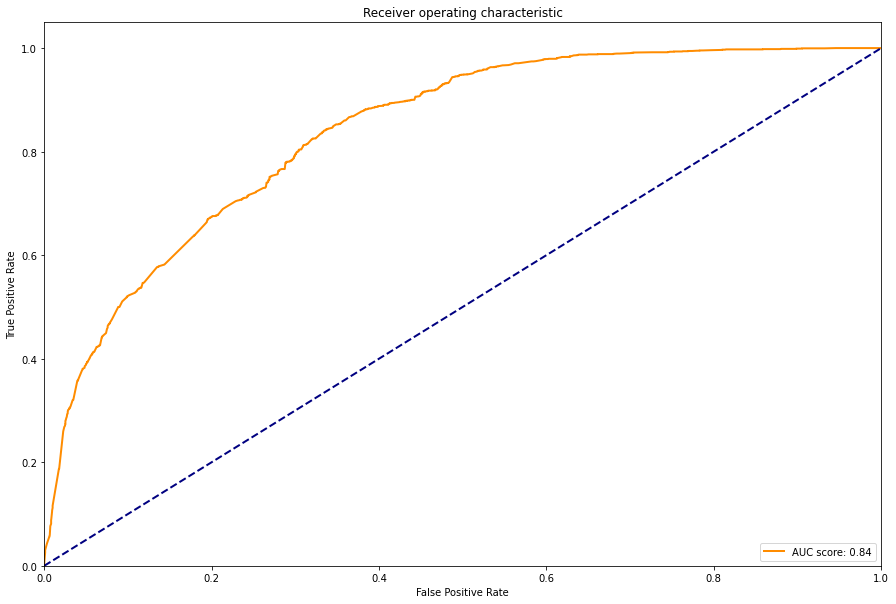

El valor de la metrica AUC-ROC para este modelo es: 0.8373411933247581


In [22]:
y_pred = categoricalNB_expandido.predict(X_exp_test)
y_pred_proba = categoricalNB_expandido.predict_proba(X_exp_test)[:,1]
graficar_auc_roc(y_exp_test, y_pred_proba)

Podemos ver que con el dataset expandido dio un AUC score bastante bueno, aunque ligeramente inferior al del dataset original.

Imprimimos el classification report:

In [23]:
print(classification_report(y_exp_test, y_pred, target_names=['No Tiene Alto Valor Adquisitivo', 'Tiene Alto Valor Adquisitivo'],digits=3))

                                 precision    recall  f1-score   support

No Tiene Alto Valor Adquisitivo      0.909     0.712     0.798      6159
   Tiene Alto Valor Adquisitivo      0.465     0.778     0.582      1982

                       accuracy                          0.728      8141
                      macro avg      0.687     0.745     0.690      8141
                   weighted avg      0.801     0.728     0.746      8141



Por último, mostramos la matriz de confusión correspondiente:

In [24]:
from funciones_auxiliares import graficar_matriz_confusion

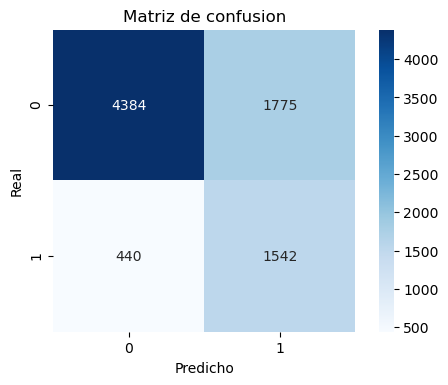

In [25]:
graficar_matriz_confusion(y_exp_test, y_pred)

A pesar de tener un AUC score más bajo, CategoricalNB con el dataset ampliado realiza una buena predicción de las instancias con alto valor adquisitivo, con un recall de 0.76. Sin embargo, clasifica peor las instancias con bajos ingresos que el modelo con el dataset original.

Nos quedamos con las probabilidades predichas por el modelo en cuestión, tanto para el subset de entrenamiento como para el de validation, para más adelante hacer un ensamble. 

In [26]:
probabilidades_categorical_exp = categoricalNB_expandido.predict_proba(X_exp_train)
probabilidades_x_test_categorical_exp = categoricalNB_expandido.predict_proba(X_exp_test)

# MultinomialNB
Seguimos con Multinomial Naive Bayes, que es un clasificador para las variables discretas.

Definimos el mejor alpha (hiperparámetro) para Multinomial Naive Bayes mediante la siguiente función de búsqueda. Nos quedamos con el alpha que maximice la métrica de comparación utilizada, que es AUC-ROC. Para compararlos, usamos k-folds cross validation.

### Entrenamiento y predicción con el dataset original
Buscamos el mejor alpha para este dataset, con la función anteriormente mencionada.

A continuación vemos todos los features del dataset. Queremos quedarnos con las variables discretas solamente.

In [27]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 12 columns):
 #   Column                                      Non-Null Count  Dtype 
---  ------                                      --------------  ----- 
 0   anios_estudiados                            32561 non-null  int64 
 1   barrio                                      32561 non-null  object
 2   categoria_de_trabajo                        32561 non-null  object
 3   edad                                        32561 non-null  int64 
 4   educacion_alcanzada                         32561 non-null  object
 5   estado_marital                              32561 non-null  object
 6   ganancia_perdida_declarada_bolsa_argentina  32561 non-null  int64 
 7   genero                                      32561 non-null  object
 8   horas_trabajo_registradas                   32561 non-null  int64 
 9   religion                                    32561 non-null  object
 10  rol_familiar_registrad

Las variables discretas son anios_estudiados, edad y horas_trabajo_registradas. Armamos un dataset solo con esas variables y realizamos el split del mismo en training y validation.

In [28]:
X_discretas = traer_variables_discretas(X)
X_discretas.info()
X_train, X_test, y_train, y_test = train_test_split(X_discretas, y, test_size=0.25, random_state=0)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 3 columns):
 #   Column                     Non-Null Count  Dtype
---  ------                     --------------  -----
 0   anios_estudiados           32561 non-null  int64
 1   edad                       32561 non-null  int64
 2   horas_trabajo_registradas  32561 non-null  int64
dtypes: int64(3)
memory usage: 763.3 KB


Buscamos el mejor alpha para los features discretos:

In [29]:
mejor_combinacion = definir_mejor_alpha(X_discretas, y, MultinomialNB())

Observamos que el mejor hiperparámetro alpha es el siguiente:

In [30]:
mejor_alpha = mejor_combinacion['alpha']
print(f'Mejor alpha: {mejor_alpha}')

Mejor alpha: 3


Entrenamos Multinomial Naive Bayes con dicho hiperparámetro:

In [31]:
multinomialNB = MultinomialNB(alpha = mejor_alpha)
multinomialNB.fit(X_train, y_train)

MultinomialNB(alpha=3)

Luego, hacemos que este prediga sobre el subset de validation. A continuación se muestra el gráfico de la curva ROC y su respectivo score en la métrica AUC-ROC.

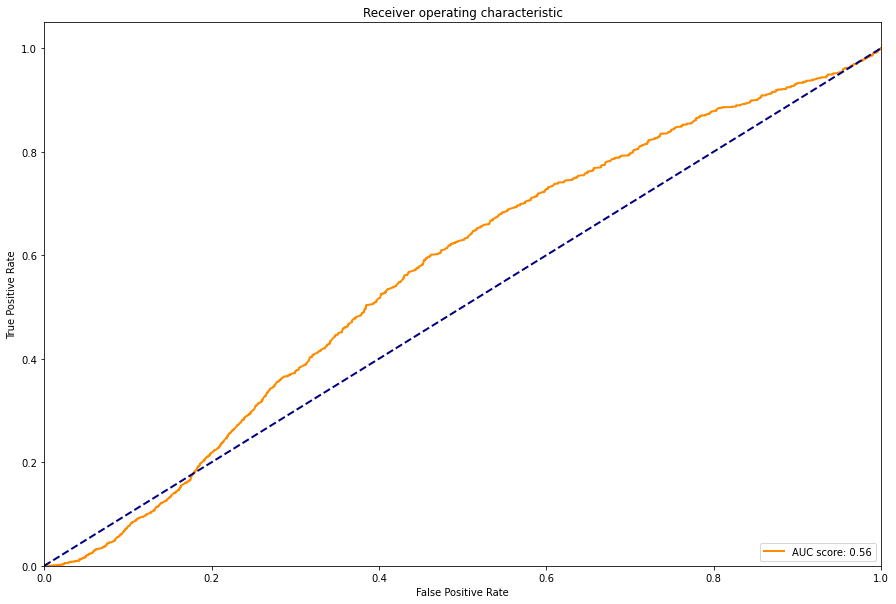

El valor de la metrica AUC-ROC para este modelo es: 0.5634842499527736


In [32]:
y_pred = multinomialNB.predict(X_test)
y_pred_proba = multinomialNB.predict_proba(X_test)[:,1]
graficar_auc_roc(y_test,y_pred_proba)

Podemos observar que el AUC score dio extremadamente bajo en comparación al resto de los modelos, concretamente 0.56. Se podría decir que esto era esperable, ya que al seleccionar únicamente los features discretos, estamos haciendo que el modelo prediga sobre una pequeña cantidad de features, que puede llevar a malos resultados.

Luego, imprimimos el classification report:

In [33]:
print(classification_report(y_test, y_pred, target_names=['No Tiene Alto Valor Adquisitivo', 'Tiene Alto Valor Adquisitivo'],digits=3))

                                 precision    recall  f1-score   support

No Tiene Alto Valor Adquisitivo      0.756     0.999     0.861      6159
   Tiene Alto Valor Adquisitivo      0.000     0.000     0.000      1982

                       accuracy                          0.756      8141
                      macro avg      0.378     0.500     0.431      8141
                   weighted avg      0.572     0.756     0.651      8141



Por último, mostramos la matriz de confusión correspondiente, donde se puede ver que básicamente predijo prácticamente todas las instancias como contribuyentes con bajo valor adquisitivo.

In [34]:
from funciones_auxiliares import graficar_matriz_confusion

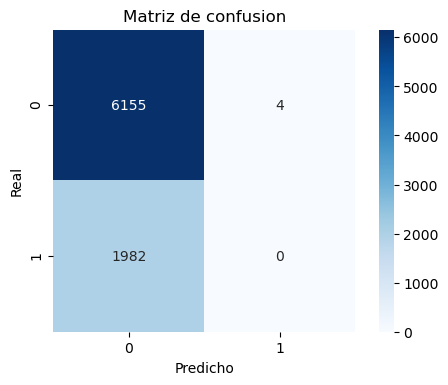

In [35]:
graficar_matriz_confusion(y_test, y_pred)

### Entrenamiento y predicción con el dataset ampliado
Como otra técnica de preprocesamiento, decidimos expandir el dataset utilizando clustering para obtener cuatro nuevas columnas. Las columnas corresponden a la utilización de K-means con 2, 4, 6 y 10 como cantidad de clusters usados.

In [36]:
from preprocessing import expandir_dataset

Expandimos el dataset y realizamos el split del mismo en los subsets de entrenamiento y validación.

In [37]:
X_exp = expandir_dataset(X_discretas)
X_exp_train, X_exp_test, y_exp_train, y_exp_test = train_test_split(X_exp, y, test_size=0.25, random_state=0)

Buscamos la mejor combinación de hiperparámetros para este dataset.

In [38]:
mejor_combinacion = definir_mejor_alpha(X_exp, y, MultinomialNB())

A continuación, vemos el mejor alpha obtenido.

In [39]:
mejor_alpha = mejor_combinacion['alpha']
print(f'Mejor alpha: {mejor_alpha}')

Mejor alpha: 10


Entrenamos Multinomial Naive Bayes con dicho hiperparámetro:

In [40]:
multinomialNB_expandido = MultinomialNB(alpha = mejor_alpha)
multinomialNB_expandido.fit(X_exp_train, y_exp_train)

MultinomialNB(alpha=10)

Luego, hacemos que este prediga sobre el subset de validation. A continuación se muestra el gráfico de la curva ROC y su respectivo score en la métrica AUC-ROC.

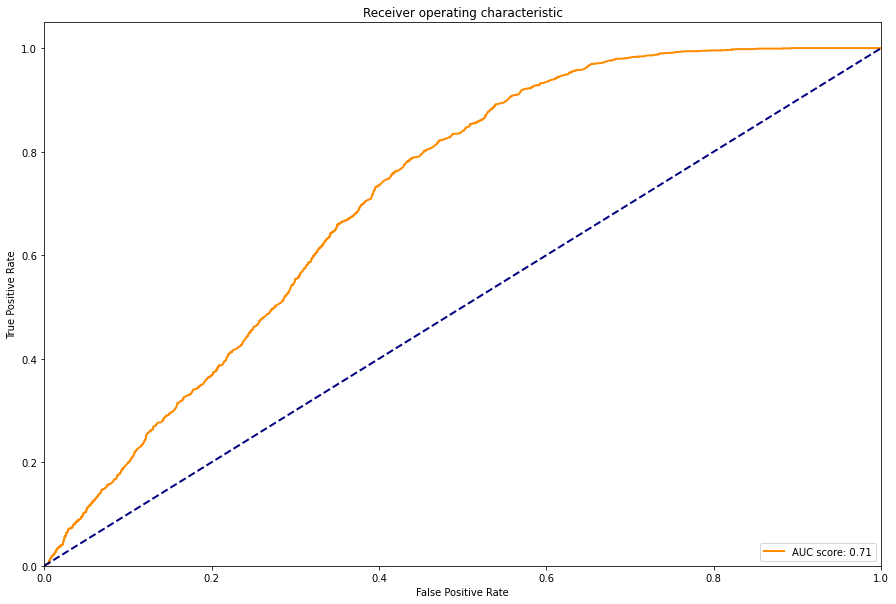

El valor de la metrica AUC-ROC para este modelo es: 0.7137061119485992


In [41]:
y_pred = multinomialNB_expandido.predict(X_exp_test)
y_pred_proba = multinomialNB_expandido.predict_proba(X_exp_test)[:,1]
graficar_auc_roc(y_exp_test, y_pred_proba)

En este caso ocurre algo similar a lo explicado anteriormente con el dataset original, aunque al ampliar el dataset hay más features sobre los que pude hacer la predicción, por lo que el AUC score fue superior en este caso (0.66).

In [42]:
print(classification_report(y_exp_test, y_pred, target_names=['No Tiene Alto Valor Adquisitivo', 'Tiene Alto Valor Adquisitivo'],digits=3))

                                 precision    recall  f1-score   support

No Tiene Alto Valor Adquisitivo      0.822     0.711     0.763      6159
   Tiene Alto Valor Adquisitivo      0.368     0.522     0.432      1982

                       accuracy                          0.665      8141
                      macro avg      0.595     0.617     0.597      8141
                   weighted avg      0.712     0.665     0.682      8141



Por último, mostramos la matriz de confusión correspondiente, donde se puede ver que básicamente predijo prácticamente todas las instancias como contribuyentes con bajo valor adquisitivo al igual que en el caso anterior.

In [43]:
from funciones_auxiliares import graficar_matriz_confusion

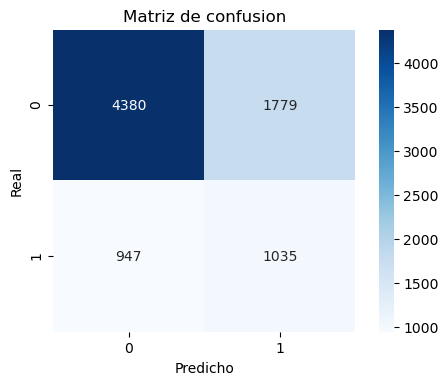

In [44]:
graficar_matriz_confusion(y_exp_test, y_pred)

# GaussianNB
Luego del mal resultado de Multinomial Naive Bayes, pasamos a hacer la predicción con Gaussian Naive Bayes, que es para variables numéricas continuas.

Definimos el mejor smoothing (hiperparámetro) para Gaussian Naive Bayes mediante la siguiente función de búsqueda. Nos quedamos con el valor de smoothing que maximice la métrica de comparación utilizada (AUC-ROC). Para compararlos, usamos k-folds cross validation.

In [45]:
def definir_mejores_hiperparametros_gaussian(X, y, modelo):
    params = {'var_smoothing': [0.000000001,0.00000001,0.0000001,0.000001,0.00001,0.0001,0.001]}
    grid_search = GridSearchCV(modelo, params, scoring='roc_auc', n_jobs=-1, cv=5).fit(X, y)    
    return grid_search.best_params_

## Gaussian Naive Bayes con variables discretas

Nos quedamos con las variables discretas de nuevo, para comparar la performance de Gaussian con Multinomial Naive Bayes y ver si mejora.

### Entrenamiento y predicción con el dataset original
Buscamos el mejor alpha para este dataset, con la función anteriormente mencionada. Realizamos el split en train y test:

In [46]:
X_discretas = traer_variables_discretas(X)
X_train, X_test, y_train, y_test = train_test_split(X_discretas, y, test_size=0.25, random_state=0)

Buscamos el mejor hiperparámetro smoothing para Gaussian NB.

In [47]:
mejor_combinacion = definir_mejores_hiperparametros_gaussian(X_discretas, y, GaussianNB())

Observamos que el mejor hiperparámetro smoothing es el siguiente:

In [48]:
mejor_smoothing = mejor_combinacion['var_smoothing']
print(f'Mejor smoothing: {mejor_smoothing}')

Mejor smoothing: 0.001


Entrenamos Gaussian Naive Bayes con dicho hiperparámetro:

In [49]:
gaussianNB = GaussianNB(var_smoothing = mejor_smoothing)
gaussianNB.fit(X_train, y_train)

GaussianNB(var_smoothing=0.001)

Luego, hacemos que este prediga sobre el subset de validation. A continuación se muestra el gráfico de la curva ROC y su respectivo score en la métrica AUC-ROC.

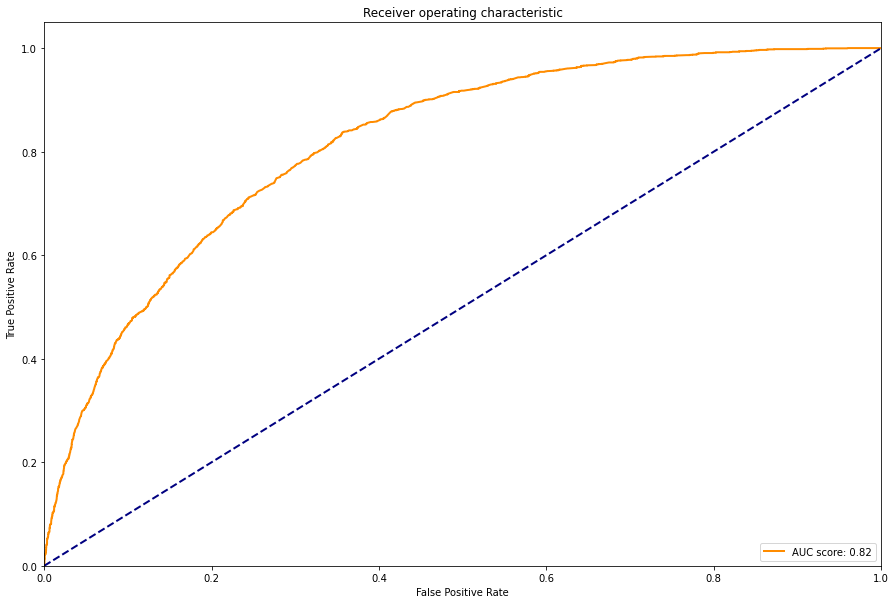

El valor de la metrica AUC-ROC para este modelo es: 0.815661295874594


In [50]:
y_pred = gaussianNB.predict(X_test)
y_pred_proba = gaussianNB.predict_proba(X_test)[:,1]
graficar_auc_roc(y_test,y_pred_proba)

Podemos observar que el AUC score dio relativamente alto, muchísimo mejor que utilizando el MultinomialNB con las mismas variables.

Luego, imprimimos el classification report:

In [51]:
print(classification_report(y_test, y_pred, target_names=['No Tiene Alto Valor Adquisitivo', 'Tiene Alto Valor Adquisitivo'],digits=3))

                                 precision    recall  f1-score   support

No Tiene Alto Valor Adquisitivo      0.819     0.937     0.874      6159
   Tiene Alto Valor Adquisitivo      0.647     0.358     0.461      1982

                       accuracy                          0.796      8141
                      macro avg      0.733     0.648     0.668      8141
                   weighted avg      0.777     0.796     0.774      8141



Seguimos viendo un muy bajo recall para las instancias con alto valor adquisitivo. Sin embargo, se ve una notoria mejora respecto al MultinomialNB.

Por último, mostramos la matriz de confusión correspondiente, donde se ve más claramente la mejora:

In [52]:
from funciones_auxiliares import graficar_matriz_confusion

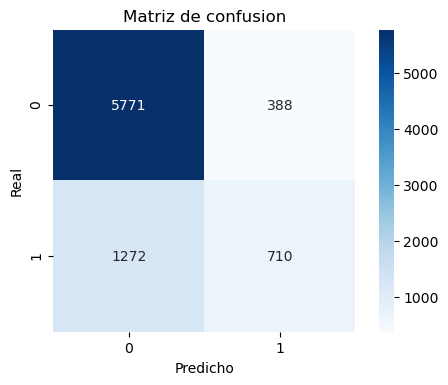

In [53]:
graficar_matriz_confusion(y_test, y_pred)

### Entrenamiento y predicción con el dataset ampliado
Como otra técnica de preprocesamiento, decidimos expandir el dataset utilizando clustering para obtener cuatro nuevas columnas. Las columnas corresponden a la utilización de K-means con 2, 4, 6 y 10 como cantidad de clusters usados.

In [54]:
from preprocessing import expandir_dataset

Expandimos el dataset y realizamos el split del mismo en los subsets de entrenamiento y validación.

In [55]:
X_exp = expandir_dataset(X_discretas)
X_exp_train, X_exp_test, y_exp_train, y_exp_test = train_test_split(X_exp, y, test_size=0.25, random_state=0)

Buscamos la mejor combinación de hiperparámetros para este dataset.

In [56]:
mejor_combinacion = definir_mejores_hiperparametros_gaussian(X_exp, y,GaussianNB())

A continuación, vemos el mejor smoothing obtenido.

In [57]:
mejor_smoothing = mejor_combinacion['var_smoothing']
print(f'Mejor smoothing: {mejor_smoothing}')

Mejor smoothing: 0.001


Entrenamos Gaussian Naive Bayes con dicho hiperparámetro:

In [58]:
gaussianNB_expandido = GaussianNB(var_smoothing = mejor_smoothing)
gaussianNB_expandido.fit(X_exp_train, y_exp_train)

GaussianNB(var_smoothing=0.001)

Luego, hacemos que este prediga sobre el subset de validation. A continuación se muestra el gráfico de la curva ROC y su respectivo score en la métrica AUC-ROC.

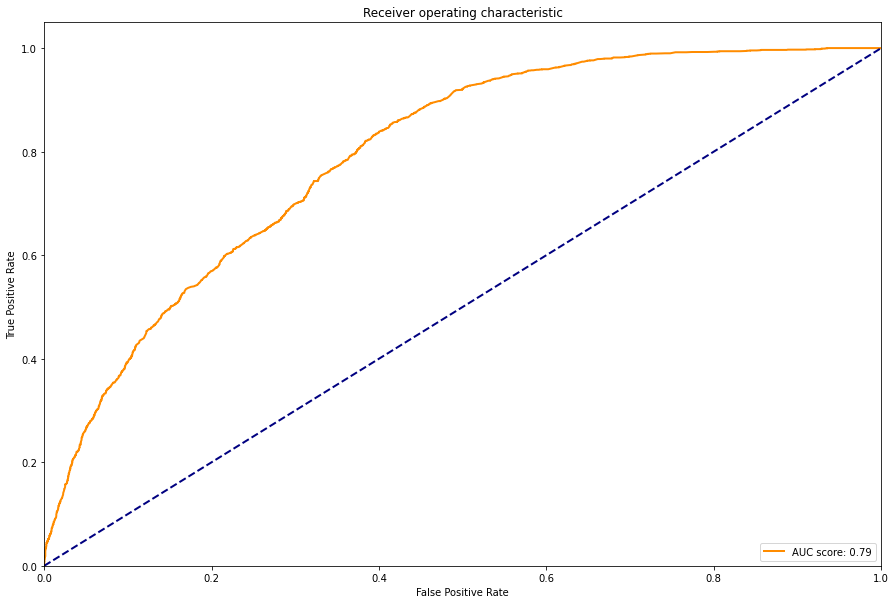

El valor de la metrica AUC-ROC para este modelo es: 0.7924652772828489


In [59]:
y_pred = gaussianNB_expandido.predict(X_exp_test)
y_pred_proba = gaussianNB_expandido.predict_proba(X_exp_test)[:,1]
graficar_auc_roc(y_exp_test, y_pred_proba)

Podemos ver que el AUC score empeora bastante con el dataset ampliado. Esto puede ser porque el clustering para la expansión del dataset no produce variables continuas, sino discretas y esto hace que el modelo funcione mal.

In [60]:
print(classification_report(y_exp_test, y_pred, target_names=['No Tiene Alto Valor Adquisitivo', 'Tiene Alto Valor Adquisitivo'],digits=3))

                                 precision    recall  f1-score   support

No Tiene Alto Valor Adquisitivo      0.847     0.820     0.833      6159
   Tiene Alto Valor Adquisitivo      0.491     0.541     0.515      1982

                       accuracy                          0.752      8141
                      macro avg      0.669     0.680     0.674      8141
                   weighted avg      0.761     0.752     0.756      8141



Ocurre algo muy similar a MultinomialNB con el dataset original, clasifica casi todas las instancias como de bajo valor adquisitivo. Esto se puede ver en la matriz de confusión correspondiente:

In [61]:
from funciones_auxiliares import graficar_matriz_confusion

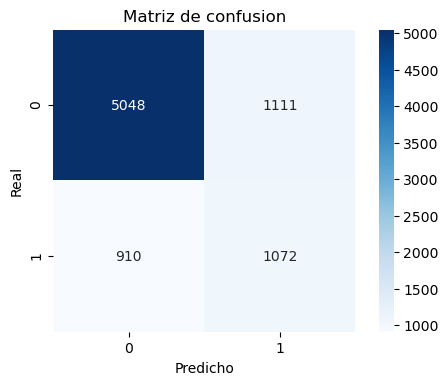

In [62]:
graficar_matriz_confusion(y_exp_test, y_pred)

## Gaussian Naive Bayes con variables numéricas
Ahora probamos con las variables numéricas, que son las mismas que las discretas, pero con el agregado de la variable 'ganancia_perdida_declarada_bolsa_argentina'.

### Entrenamiento y predicción con el dataset original
Traemos las variables numéricas y hacemos el split del dataset en training y validation.

In [63]:
X_numericas = traer_variables_numericas(X)
X_train, X_test, y_train, y_test = train_test_split(X_numericas, y, test_size=0.25, random_state=0)

Buscamos el mejor smoothing con la función anteriormente mencionada:

In [64]:
mejor_combinacion = definir_mejores_hiperparametros_gaussian(X_numericas, y, GaussianNB())

Observamos que el mejor hiperparámetro smoothing es el siguiente:

In [65]:
mejor_smoothing = mejor_combinacion['var_smoothing']
print(f'Mejor smoothing: {mejor_smoothing}')

Mejor smoothing: 1e-08


Entrenamos Gaussian Naive Bayes con dicho hiperparámetro:

In [66]:
gaussianNB = GaussianNB(var_smoothing = mejor_smoothing)
gaussianNB.fit(X_train, y_train)

GaussianNB(var_smoothing=1e-08)

Luego, hacemos que este prediga sobre el subset de validation. A continuación se muestra el gráfico de la curva ROC y su respectivo score en la métrica AUC-ROC.

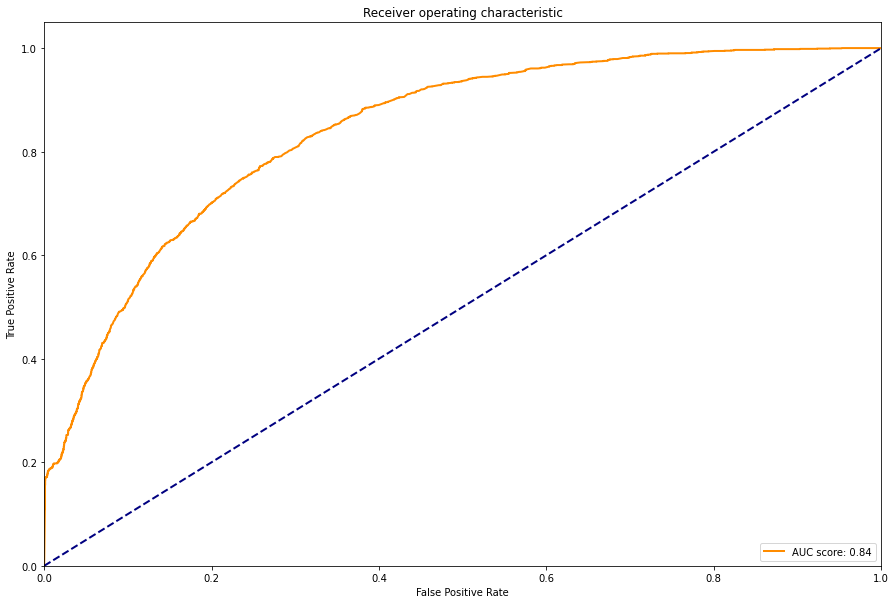

El valor de la metrica AUC-ROC para este modelo es: 0.840012826921429


In [67]:
y_pred = gaussianNB.predict(X_test)
y_pred_proba = gaussianNB.predict_proba(X_test)[:,1]
graficar_auc_roc(y_test,y_pred_proba)

Obtuvimos un AUC score bastante alto, concretamente de 0.84.

Ahora imprimimos el classification report correspondiente:

In [68]:
print(classification_report(y_test, y_pred, target_names=['No Tiene Alto Valor Adquisitivo', 'Tiene Alto Valor Adquisitivo'],digits=3))

                                 precision    recall  f1-score   support

No Tiene Alto Valor Adquisitivo      0.798     0.976     0.878      6159
   Tiene Alto Valor Adquisitivo      0.760     0.232     0.355      1982

                       accuracy                          0.795      8141
                      macro avg      0.779     0.604     0.617      8141
                   weighted avg      0.789     0.795     0.751      8141



Se puede ver un buen f1-score para las instancias que no tienen alto valor adquisitivo. Sin embargo, para las instancias con altos ingresos, se ve un f1-score muy bajo, pues el recall es 0.23, ya que no clasifica muy bien a las instancias con alto valor adquisitivo. Esto es más evidente viendo la matriz de confusión:

In [69]:
from funciones_auxiliares import graficar_matriz_confusion

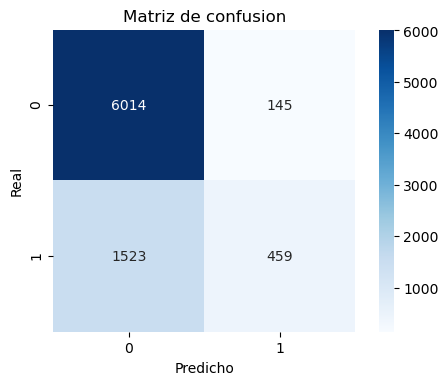

In [70]:
graficar_matriz_confusion(y_test, y_pred)

Nos quedamos con las probabilidades predichas por GaussianNB, tanto para el subset de entrenamiento como para el de validation.

In [71]:
probabilidades_gaussian = gaussianNB.predict_proba(X_train)
probabilidades_x_test_gaussian = gaussianNB.predict_proba(X_test)

### Entrenamiento y predicción con el dataset ampliado

In [72]:
from preprocessing import expandir_dataset

Expandimos el dataset y realizamos el split del mismo en los subsets de entrenamiento y validación.

In [73]:
X_exp = expandir_dataset(X_numericas)
X_exp_train, X_exp_test, y_exp_train, y_exp_test = train_test_split(X_exp, y, test_size=0.25, random_state=0)

Buscamos la mejor combinación de hiperparámetros para este dataset.

In [74]:
mejor_combinacion = definir_mejores_hiperparametros_gaussian(X_exp, y, GaussianNB())

A continuación, vemos el mejor smoothing obtenido.

In [75]:
mejor_smoothing = mejor_combinacion['var_smoothing']
print(f'Mejor smoothing: {mejor_smoothing}')

Mejor smoothing: 1e-07


Entrenamos Gaussian Naive Bayes con dicho hiperparámetro:

In [76]:
gaussianNB_expandido = GaussianNB(var_smoothing = mejor_smoothing)
gaussianNB_expandido.fit(X_exp_train, y_exp_train)

GaussianNB(var_smoothing=1e-07)

Luego, hacemos que este prediga sobre el subset de validation. A continuación se muestra el gráfico de la curva ROC y su respectivo score en la métrica AUC-ROC.

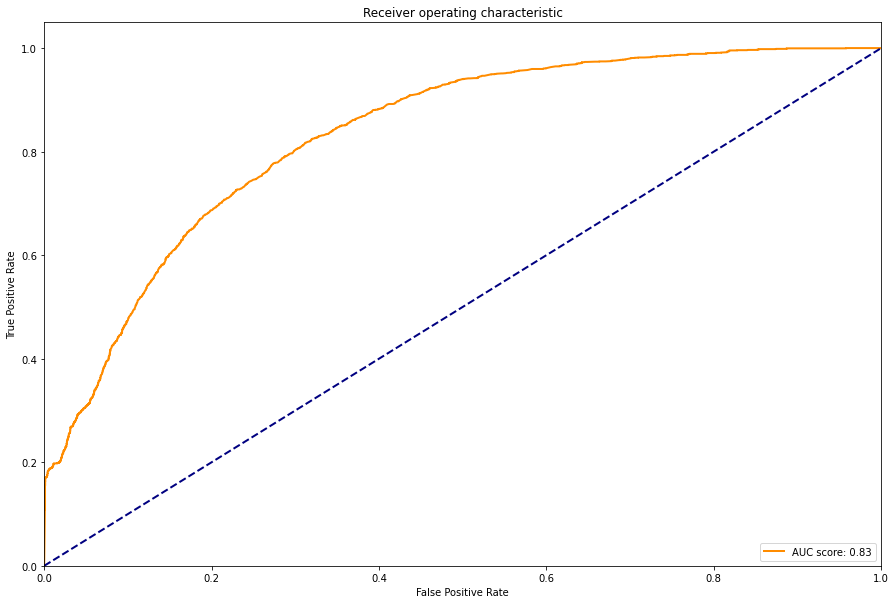

El valor de la metrica AUC-ROC para este modelo es: 0.8317044912574921


In [77]:
y_pred = gaussianNB_expandido.predict(X_exp_test)
y_pred_proba = gaussianNB_expandido.predict_proba(X_exp_test)[:,1]
graficar_auc_roc(y_exp_test, y_pred_proba)

El AUC score es muy similar al del dataset original, pero disminuye muy levemente, de 0.84 a 0.83.

In [78]:
print(classification_report(y_exp_test, y_pred, target_names=['No Tiene Alto Valor Adquisitivo', 'Tiene Alto Valor Adquisitivo'],digits=3))

                                 precision    recall  f1-score   support

No Tiene Alto Valor Adquisitivo      0.802     0.970     0.878      6159
   Tiene Alto Valor Adquisitivo      0.733     0.255     0.379      1982

                       accuracy                          0.796      8141
                      macro avg      0.768     0.613     0.628      8141
                   weighted avg      0.785     0.796     0.756      8141



Por último, mostramos la matriz de confusión correspondiente, se ve un resultado muy similar al de GaussianNB con el dataset original:

In [79]:
from funciones_auxiliares import graficar_matriz_confusion

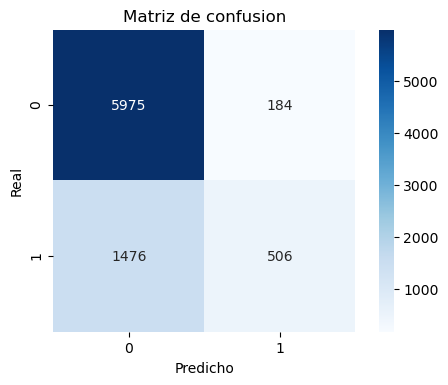

In [80]:
graficar_matriz_confusion(y_exp_test, y_pred)

Nos quedamos con las probabilidades predichas por GaussianNB usando el dataset ampliado, tanto para el subset de entrenamiento como para el de validation.

In [81]:
probabilidades_gaussian_exp = gaussianNB_expandido.predict_proba(X_exp_train)
probabilidades_x_test_gaussian_exp = gaussianNB_expandido.predict_proba(X_exp_test)

# Ensamble Gaussiano
Realizamos un ensamble entre las probabilidades predichas por el CategoricalNB y GaussianNB, que nos proporcionaron buenos resultados, utilizando GaussianNB.

Buscamos el mejor hiperparámetro smoothing para este GaussianNB con la siguiente función de búsqueda. Esta recibe un array de las probabilidades del CategoricalNB y GaussianNB, y la variable target (y). Utilizamos k-folds cross validation para comparar los modelos con distintos smoothing.

In [82]:
def definir_mejores_hiperparametros_ensamble(array_probabilidades, y, modelo):
    params = {'var_smoothing': [0.000000001,0.00000001,0.0000001,0.000001,0.00001,0.0001,0.001]}
    grid_search = GridSearchCV(modelo, params, scoring='roc_auc', n_jobs=-1, cv=5).fit(array_probabilidades, y)    
    return grid_search.best_params_

### Entrenamiento y predicción con el dataset original

Hacemos un array de las probabilidades de ambos modelos, de X_train y X_test por separado, para pasarle a la función que define el mejor smoothing para el ensamble.

In [83]:
probabilidades_x_train = np.hstack((probabilidades_categorical, probabilidades_gaussian))
probabilidades_x_test = np.hstack((probabilidades_x_test_categorical, probabilidades_x_test_gaussian))

Unimos X_train y X_test para pasarlos a la función de búsqueda, y buscamos el mejor smoothing con dicha función:

In [84]:
X_ensamble_gaussiano = np.vstack((probabilidades_x_train, probabilidades_x_test))
mejor_combinacion = definir_mejores_hiperparametros_ensamble(X_ensamble_gaussiano, y, GaussianNB())

Observamos que el mejor smoothing es el siguiente:

In [85]:
mejor_smoothing = mejor_combinacion['var_smoothing']
print(f'Mejor smoothing: {mejor_smoothing}')

Mejor smoothing: 0.001


Entrenamos el ensamble gaussiano con dicho hiperparámetro:

In [86]:
ensamble_gaussiano = GaussianNB(var_smoothing = mejor_smoothing)
ensamble_gaussiano.fit(probabilidades_x_train, y_train)

GaussianNB(var_smoothing=0.001)

Luego, hacemos que este prediga sobre el subset de validation. A continuación se muestra el gráfico de la curva ROC y su respectivo score en la métrica AUC-ROC.

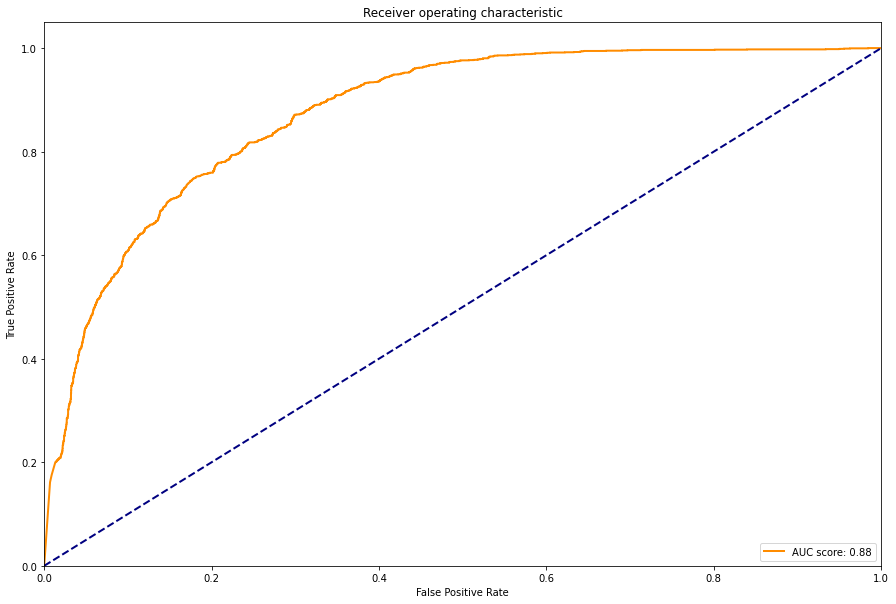

El valor de la metrica AUC-ROC para este modelo es: 0.8753559597671461


In [87]:
y_pred = ensamble_gaussiano.predict(probabilidades_x_test)
y_pred_proba = ensamble_gaussiano.predict_proba(probabilidades_x_test)[:,1]
graficar_auc_roc(y_test, y_pred_proba)

Vemos un muy buen resultado de AUC score (0.88) con el Ensamble Gaussiano de probabilidades. Esto tiene sentido, ya que estamos utilizando un modelo generado a partir de los anteriores.

In [88]:
print(classification_report(y_test, y_pred, target_names=['No Tiene Alto Valor Adquisitivo', 'Tiene Alto Valor Adquisitivo'],digits=3))

                                 precision    recall  f1-score   support

No Tiene Alto Valor Adquisitivo      0.882     0.892     0.887      6159
   Tiene Alto Valor Adquisitivo      0.652     0.630     0.641      1982

                       accuracy                          0.828      8141
                      macro avg      0.767     0.761     0.764      8141
                   weighted avg      0.826     0.828     0.827      8141



Se puede observar un alto precision y recall para las instancias con bajos ingresos, y regulares para las instancias de altos ingresos.
Por último, mostramos la matriz de confusión correspondiente, donde se puede ver la clasificación realizada de forma más explícita:

In [89]:
from funciones_auxiliares import graficar_matriz_confusion

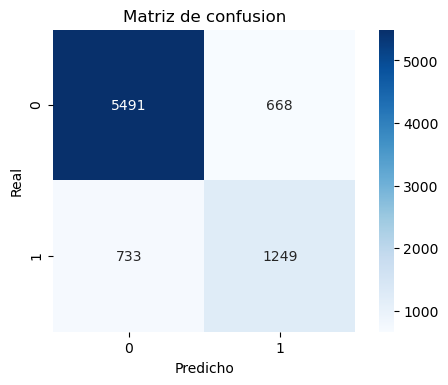

In [90]:
graficar_matriz_confusion(y_test, y_pred)

### Entrenamiento y predicción con el dataset ampliado

Hacemos un array de las probabilidades de ambos modelos, de X_train y X_test por separado (para el dataset expandido), para pasarle a la función que define el mejor smoothing para el ensamble.

In [91]:
probabilidades_x_train_exp = np.hstack(( probabilidades_categorical_exp , probabilidades_gaussian_exp))
probabilidades_x_test_exp = np.hstack(( probabilidades_x_test_categorical_exp , probabilidades_x_test_gaussian_exp))

Unimos X_train y X_test para pasarlos a la función de búsqueda, y buscamos el mejor smoothing con dicha función:

In [92]:
X_ensamble_gaussiano_exp = np.vstack((probabilidades_x_train_exp, probabilidades_x_test_exp))
mejor_combinacion = definir_mejores_hiperparametros_ensamble(X_ensamble_gaussiano_exp, y, GaussianNB())

Observamos que el mejor smoothing es el siguiente:

In [93]:
mejor_smoothing = mejor_combinacion['var_smoothing']
print(f'Mejor smoothing: {mejor_smoothing}')

Mejor smoothing: 0.0001


Entrenamos el ensamble gaussiano con dicho hiperparámetro:

In [94]:
ensamble_gaussiano_expandido = GaussianNB(var_smoothing = mejor_smoothing)
ensamble_gaussiano_expandido.fit(probabilidades_x_train_exp, y_train)

GaussianNB(var_smoothing=0.0001)

Luego, hacemos que este prediga sobre el subset de validation. A continuación se muestra el gráfico de la curva ROC y su respectivo score en la métrica AUC-ROC.

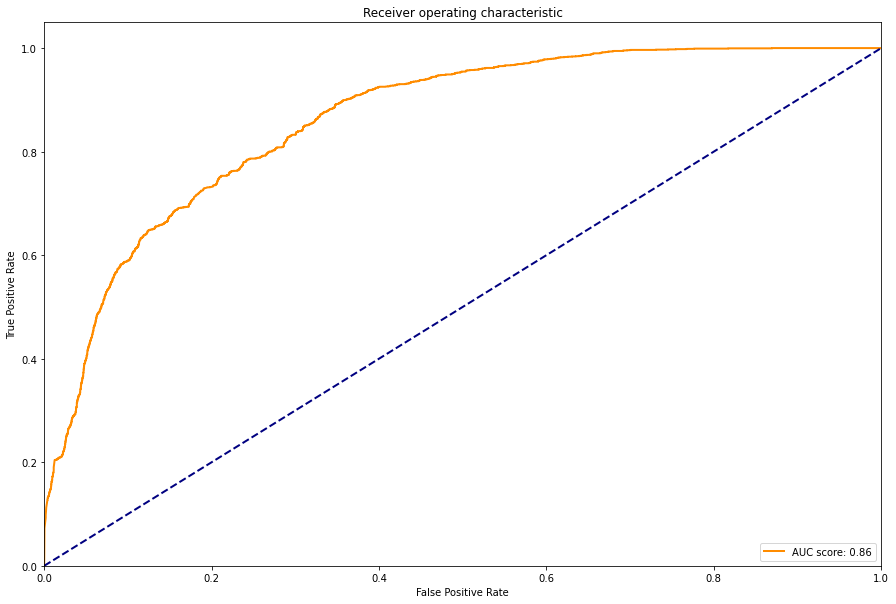

El valor de la metrica AUC-ROC para este modelo es: 0.861205345593701


In [95]:
y_pred = ensamble_gaussiano_expandido.predict(probabilidades_x_test_exp)
y_pred_proba = ensamble_gaussiano_expandido.predict_proba(probabilidades_x_test_exp)[:,1]
graficar_auc_roc(y_exp_test, y_pred_proba)

El AUC score empeoró ligeramente respecto al obtenido con el ensamble realizando su predicción en el dataset original.

In [96]:
print(classification_report(y_exp_test, y_pred, target_names=['No Tiene Alto Valor Adquisitivo', 'Tiene Alto Valor Adquisitivo'],digits=3))

                                 precision    recall  f1-score   support

No Tiene Alto Valor Adquisitivo      0.810     0.963     0.880      6159
   Tiene Alto Valor Adquisitivo      0.719     0.297     0.420      1982

                       accuracy                          0.801      8141
                      macro avg      0.764     0.630     0.650      8141
                   weighted avg      0.788     0.801     0.768      8141



Se puede ver que, a pesar de que mejora el recall para las instancias que no tienen alto valor adquisitivo, el mismo empeora considerablemente para aquellas que si tienen alto valor adquisitivo. Esto se ve más claramente en la matriz de confusión:

In [97]:
from funciones_auxiliares import graficar_matriz_confusion

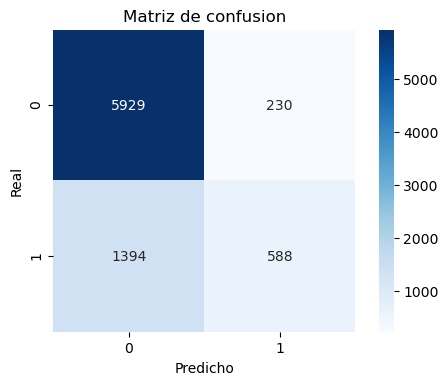

In [98]:
graficar_matriz_confusion(y_exp_test, y_pred)

## Predicción con el dataset de test holdout
A continuación, realizamos la predicción con el Ensamble Gaussiano con el dataset original sobre el dataset de holdout, ya que es el que mejor se desempeñó según la métrica AUC-ROC, y la escribimos al archivo 'EnsambleGaussiano.csv'

In [99]:
from funciones_auxiliares import traer_holdout
from preprocessing import preparar_holdout
from funciones_auxiliares import escribir_predicciones

In [100]:
holdout = traer_holdout()
ids, holdout = preparar_holdout(holdout)

In [101]:
holdout_categoricas = traer_variables_categoricas(holdout)
holdout_categoricas = aplicar_one_hot_encoding(holdout_categoricas)

holdout_numericas = traer_variables_numericas(holdout)

probabilidades_categorical = categoricalNB.predict_proba(holdout_categoricas)
probabilidades_gaussian = gaussianNB.predict_proba(holdout_numericas)

probabilidades_holdout = np.hstack((probabilidades_categorical, probabilidades_gaussian))

In [102]:
predicciones = ensamble_gaussiano.predict(probabilidades_holdout)
escribir_predicciones(ids, predicciones, "EnsambleGaussiano")